## Step 1: Load libraries and Setup Environment

The system() function will be used to interact with R and manage your workflow. We use mamba to install the necessary bioinformatics packages directly from the R environment.


In [1]:
# Download Miniforge
system("curl -L -O https://github.com/conda-forge/miniforge/releases/latest/download/Miniforge3-$(uname)-$(uname -m).sh", ignore.stdout = TRUE, ignore.stderr = TRUE)

# Install Miniforge (you can change the path as needed)
system("bash Miniforge3-$(uname)-$(uname -m).sh -b -u -p $HOME/miniforge", ignore.stdout = TRUE, ignore.stderr = TRUE)

# Update PATH to point to the Miniforge bin files
Sys.setenv(PATH = paste0(Sys.getenv("HOME"), "/miniforge/bin:", Sys.getenv("PATH")))

In [2]:
# Use mamba to install the required bioinformatics packages
system("mamba install -y -c conda-forge -c bioconda fastqc multiqc entrez-direct parallel-fastq-dump sra-tools samtools subread")

In [3]:
# Install packages if not already installed
if (!requireNamespace("BiocManager", quietly = TRUE))
  install.packages("BiocManager")

BiocManager::install(c("DESeq2", "ggplot2", "pheatmap", "apeglm", "ggrepel", "EnhancedVolcano", "ComplexHeatmap", "RColorBrewer", "plotly", "base64enc"))

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.19 (BiocManager 1.30.25), R 4.4.1 (2024-06-14)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'ggplot2' 'RColorBrewer' 'base64enc'”
Installing package(s) 'BiocVersion', 'DESeq2', 'pheatmap', 'apeglm', 'ggrepel',
  'EnhancedVolcano', 'ComplexHeatmap', 'plotly'

also installing the dependencies ‘UCSC.utils’, ‘GenomeInfoDbData’, ‘zlibbioc’, ‘abind’, ‘SparseArray’, ‘lambda.r’, ‘futile.options’, ‘bdsmatrix’, ‘mvtnorm’, ‘GenomeInfoDb’, ‘XVector’, ‘S4Arrays’, ‘DelayedArray’, ‘futile.logger’, ‘snow’, ‘BH’, ‘coda’, ‘bbmle’, ‘rjson’, ‘S4Vectors’, ‘IRanges’, ‘GenomicRanges’, ‘SummarizedExperiment’, ‘BiocGenerics’, ‘Biobase

In [4]:
# Load libraries
library(DESeq2)
library(ggplot2)
library(pheatmap)
library(apeglm) 
library(ggrepel) 
library(EnhancedVolcano)
library(RColorBrewer)
library(ComplexHeatmap)
library(plotly)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following object is masked from ‘package:utils’:

    findMatches


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb

Loa

In [5]:
# Pull the Docker image
system("docker pull encodedcc/mirna-seq-pipeline:1.2.2")

In [6]:
# Create necessary directories on your host machine (outside Docker)
dir.create("data", recursive = TRUE)
dir.create("data/aligned_bam")
dir.create("data/fastqc")
dir.create("data/fastqc_samples")
dir.create("data/raw_fastq")
dir.create("data/reference")
dir.create("data/sample_STAR")
dir.create("data/star_output")
dir.create("data/trimmed")
dir.create("data/zebrafish_STAR_index")

Warning message in dir.create("data", recursive = TRUE):
“'data' already exists”
Warning message in dir.create("data/aligned_bam"):
“'data/aligned_bam' already exists”
Warning message in dir.create("data/fastqc"):
“'data/fastqc' already exists”
Warning message in dir.create("data/fastqc_samples"):
“'data/fastqc_samples' already exists”
Warning message in dir.create("data/raw_fastq"):
“'data/raw_fastq' already exists”
Warning message in dir.create("data/reference"):
“'data/reference' already exists”
Warning message in dir.create("data/sample_STAR"):
“'data/sample_STAR' already exists”
Warning message in dir.create("data/star_output"):
“'data/star_output' already exists”
Warning message in dir.create("data/trimmed"):
“'data/trimmed' already exists”
Warning message in dir.create("data/zebrafish_STAR_index"):
“'data/zebrafish_STAR_index' already exists”


In [7]:
# Detect number of cores
num_cores <- parallel::detectCores(logical = TRUE)
THREADS <- max(1, num_cores - 1)
print(paste("Number of threads:", THREADS))

[1] "Number of threads: 7"


Executing the SRA Toolkit commands to fetch accession numbers.

In [8]:
system("esearch -db sra -query 'PRJNA418313' | efetch -format runinfo > all_sra_info.txt")
system("grep -E 'GSM2856755|GSM2856756|GSM2856757|GSM2856761|GSM2856762|GSM2856763' all_sra_info.txt | cut -d',' -f1 > accs.txt")
system("cat accs.txt")

## Step 2: Download Data and Reference Files


The prefetch command will access Sequence Read Archive (SRA) records (SRR) in parallel and download the corresponding FastQ files from the NCBI database.

In [9]:
# Download multiple files using the SRA-Toolkit with parallel threads
system(paste("cat accs.txt | xargs -P", THREADS, "-I {} prefetch {} -O data/raw_fastq -f yes"))

The reference genome, annotation information for mouse genome, and the primer adapter are download from S3 bucket.

In [10]:
# Download genome and annotation files
system("wget -P data/reference/ https://sra-data-athena.s3.amazonaws.com/reference/GRCz11.fa")
system("wget -P data/reference/ https://sra-data-athena.s3.amazonaws.com/reference/dre_zebrafish.gtf")
system("wget -P data/trimmed/ https://sra-data-athena.s3.amazonaws.com/reference/three_prime_adapter.fa")

## Step 3: Download and Convert SRA to FASTQ

Run the this command to download and convert SRA files to FASTQ using the prefetch and fasterq-dump tools.

In [11]:
# Convert SRA files to Fastq format using fastq-dump
system(paste("cat accs.txt | xargs -P", THREADS, "-I {} fastq-dump --outdir data/raw_fastq/ --gzip data/raw_fastq/{}/{}.sra"))

## Step 4: Run FastQC

Run FastQC to analyze the quality of the FASTQ files, and then generate a MultiQC report.

In [12]:
# Run FastQC on the downloaded Fastq files
system(paste("cat accs.txt | xargs -P", THREADS, "-I {} fastqc data/raw_fastq/{}.fastq.gz -o data/fastqc/"))

In [13]:
# Run MultiQC to generate a combined QC report
system("multiqc -f data/fastqc/")

# Read and display the MultiQC data using R's data frames
multiqc_data <- read.csv("./multiqc_data/multiqc_fastqc.txt", sep = "\t")
print(multiqc_data)

       Sample            Filename               File.type              Encoding
1          S1         S1.fastq.gz Conventional base calls Sanger / Illumina 1.9
2         S10        S10.fastq.gz Conventional base calls Sanger / Illumina 1.9
3         S11        S11.fastq.gz Conventional base calls Sanger / Illumina 1.9
4         S12        S12.fastq.gz Conventional base calls Sanger / Illumina 1.9
5         S13        S13.fastq.gz Conventional base calls Sanger / Illumina 1.9
6         S14        S14.fastq.gz Conventional base calls Sanger / Illumina 1.9
7         S15        S15.fastq.gz Conventional base calls Sanger / Illumina 1.9
8         S16        S16.fastq.gz Conventional base calls Sanger / Illumina 1.9
9          S2         S2.fastq.gz Conventional base calls Sanger / Illumina 1.9
10         S3         S3.fastq.gz Conventional base calls Sanger / Illumina 1.9
11         S4         S4.fastq.gz Conventional base calls Sanger / Illumina 1.9
12         S5         S5.fastq.gz Conven

## Step 5: Adapter Trimming using Cutadapt

The code uses Docker to run cutadapt on each FASTQ file, removing adapter sequences and saving the trimmed results to the specified output directory.

In [14]:
# Define the list of SRA accessions from your file
accs_ids <- readLines("accs.txt")

# Specify adapter file location
adapter_file <- "data/trimmed/three_prime_adapter.fa"
trimmed_output_dir <- "data/trimmed"

# Run cutadapt in Docker for each accession
for (i in 1:length(accs_ids)) {
  acc <- accs_ids[i]
  input_fastq <- paste0("data/raw_fastq/", acc, ".fastq.gz")
  trimmed_fastq <- paste0(trimmed_output_dir, "/", acc, "_trimmed.fastq")

  # Run cutadapt inside Docker
  system(paste0(
    "docker run --rm -v ", getwd(), ":/data ",
    "encodedcc/mirna-seq-pipeline:1.2.2 ",
    "cutadapt -a file:/data/", adapter_file, " -e 0.25 -m 15 -M 30 ",
    " --untrimmed-output /data/", trimmed_output_dir, "/", acc, "_untrimmed.fastq",
    " -o /data/", trimmed_output_dir, "/", acc, "_trimmed.fastq",
    " --cores ", THREADS, " /data/", input_fastq
  ))
}

## Step 6: Run Fastqc

Run Fastqc after cutadapt to ensure that the trimmed FASTQ files are of good quality before proceeding with STAR.

In [15]:
# Run FastQC on the downloaded Fastq files
system(paste("cat accs.txt | xargs -P", THREADS, "-I {} fastqc data/trimmed/{}.fastq -o data/fastqc_samples"))

In [16]:
# Run MultiQC to generate a combined QC report
system("multiqc -f data/fastqc_samples/")

# Read and display the MultiQC data using R's data frames
multiqc_data <- read.csv("./multiqc_data/multiqc_fastqc.txt", sep = "\t")
print(multiqc_data)

       Sample            Filename               File.type              Encoding
1          S1         S1.fastq.gz Conventional base calls Sanger / Illumina 1.9
2         S10        S10.fastq.gz Conventional base calls Sanger / Illumina 1.9
3         S11        S11.fastq.gz Conventional base calls Sanger / Illumina 1.9
4         S12        S12.fastq.gz Conventional base calls Sanger / Illumina 1.9
5         S13        S13.fastq.gz Conventional base calls Sanger / Illumina 1.9
6         S14        S14.fastq.gz Conventional base calls Sanger / Illumina 1.9
7         S15        S15.fastq.gz Conventional base calls Sanger / Illumina 1.9
8         S16        S16.fastq.gz Conventional base calls Sanger / Illumina 1.9
9          S2         S2.fastq.gz Conventional base calls Sanger / Illumina 1.9
10         S3         S3.fastq.gz Conventional base calls Sanger / Illumina 1.9
11         S4         S4.fastq.gz Conventional base calls Sanger / Illumina 1.9
12         S5         S5.fastq.gz Conven

## Step 7: STAR Genome Indexing

STAR is a genome aligner that requires a pre-built genome index to efficiently map reads to the reference genome. This step creates a genome index for the zebrafish reference genome, which will be used in the subsequent alignment step.

In [17]:
# Run STAR genome indexing inside Docker
system(paste0(
  "docker run --rm -v ", getwd(), ":/data ",
      "encodedcc/mirna-seq-pipeline:1.2.2 ",
  "STAR --runThreadN ", THREADS, 
  " --runMode genomeGenerate",
  " --genomeDir /data/data/zebrafish_STAR_index",
  " --genomeFastaFiles /data/data/reference/GRCz11.fa",
  " --sjdbGTFfile /data/data/reference/dre_zebrafish.gtf",
  " --sjdbOverhang 1 --limitGenomeGenerateRAM 29000000000"
))

## Step 8: STAR Genome Alignment

After create the alignment it will get the trimmed FASTQ files and align to the reference genome using the STAR aligner. The aligned reads are then used for downstream analysis, such as differential gene expression analysis.

In [18]:
# Read accession IDs from the file
accs_ids <- readLines("accs.txt")

# Loop through each accession ID
for (i in 1:length(accs_ids)) {
  acc <- accs_ids[i]

  # Construct the command
  system(paste0(
    "docker run --rm -v ", getwd(), ":/data ",
    "encodedcc/mirna-seq-pipeline:1.2.2 ",
    "STAR --genomeDir /data/data/zebrafish_STAR_index ",
    " --readFilesIn /data/data/trimmed/", acc, "_trimmed.fastq ",
    " --sjdbGTFfile /data/data/reference/dre_zebrafish.gtf ",
    " --runThreadN ", THREADS,
    " --alignEndsType EndToEnd ",
    " --outFilterMismatchNmax 1 ",
    " --outFilterMultimapScoreRange 0 ",
    " --quantMode TranscriptomeSAM GeneCounts ",
    " --outReadsUnmapped Fastx ",
    " --outSAMtype BAM SortedByCoordinate ",
    " --outFilterMultimapNmax 10 ",
    " --outSAMunmapped Within ",
    " --outFilterScoreMinOverLread 0 ",
    " --outFilterMatchNminOverLread 0 ",
    " --outFilterMatchNmin 16 ",
    " --alignSJDBoverhangMin 1000 ",
    " --alignIntronMax 1 ",
    " --outWigType wiggle ",
    " --outWigStrand Stranded ",
    " --outWigNorm RPM ",
    "--outFileNamePrefix /data/data/star_output/", acc, "_"
  ))
}

## Step 9: Accessing Results

Now, this step processes the gene count files generated by STAR and combines them into a single data frame for further analysis.

In [19]:
# Set up libraries
library(dplyr)

# Define the accession IDs and output directory
accs <- c("SRR6289638", "SRR6289639", "SRR6289640", "SRR6289644", "SRR6289645", "SRR6289646")
output_dir <- "data/star_output/"

# Create a function to read in gene counts from STAR output
read_gene_counts <- function(acc, output_dir) {
  filepath <- file.path(output_dir, paste0(acc, "_ReadsPerGene.out.tab"))
  # Read the data and extract the second column (unstranded counts)
  gene_counts <- read.table(filepath, header = FALSE, sep = "\t", stringsAsFactors = FALSE)
  gene_counts <- gene_counts[, c(1, 2)]  # First column is gene, second is unstranded counts
  colnames(gene_counts) <- c("Gene", acc)
  return(gene_counts)
}

# Initialize the combined matrix with the first file
combined_counts <- read_gene_counts(accs[1], output_dir)

# Loop through the remaining files and merge the counts by gene
for (i in 2:length(accs)) {
  acc <- accs[i]
  gene_counts <- read_gene_counts(acc, output_dir)
  combined_counts <- full_join(combined_counts, gene_counts, by = "Gene")
}

# View the combined gene counts
head(combined_counts)



Attaching package: ‘dplyr’


The following object is masked from ‘package:Biobase’:

    combine


The following object is masked from ‘package:matrixStats’:

    count


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




,Gene,SRR6289638,SRR6289639,SRR6289640,SRR6289644,SRR6289645,SRR6289646
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>
1,N_unmapped,2083922,2106372,2399367,2552057,2669409,2623787
2,N_multimapping,6634139,7846989,6635426,6732473,6197060,7207335
3,N_noFeature,605293,570212,611152,684768,653152,761172
4,N_ambiguous,0,0,0,0,0,0
5,Dre-Mir-155_pre,42,65,44,189,102,96
6,Dre-Mir-459_pre,0,0,4,1,0,0


The differential expression analysis using the DESeq2 package to identify genes that show significant changes in expression between the two experimental conditions ("0dpa" and "3dpa").

In [20]:
# Load necessary libraries
library(DESeq2)

# Prepare the count matrix
rownames(combined_counts) <- combined_counts$Gene
count_data <- as.matrix(combined_counts[, -1])

# Define sample conditions (e.g., two groups: control vs treatment)
conditions <- factor(c("0dpa", "0dpa", "0dpa", "3dpa", "3dpa", "3dpa"))
coldata <- data.frame(row.names = accs, condition = conditions)

# Create DESeq2 dataset
dds <- DESeqDataSetFromMatrix(countData = count_data, colData = coldata, design = ~ condition)

# Run DESeq2
dds <- DESeq(dds)

# Get results
res <- results(dds)


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



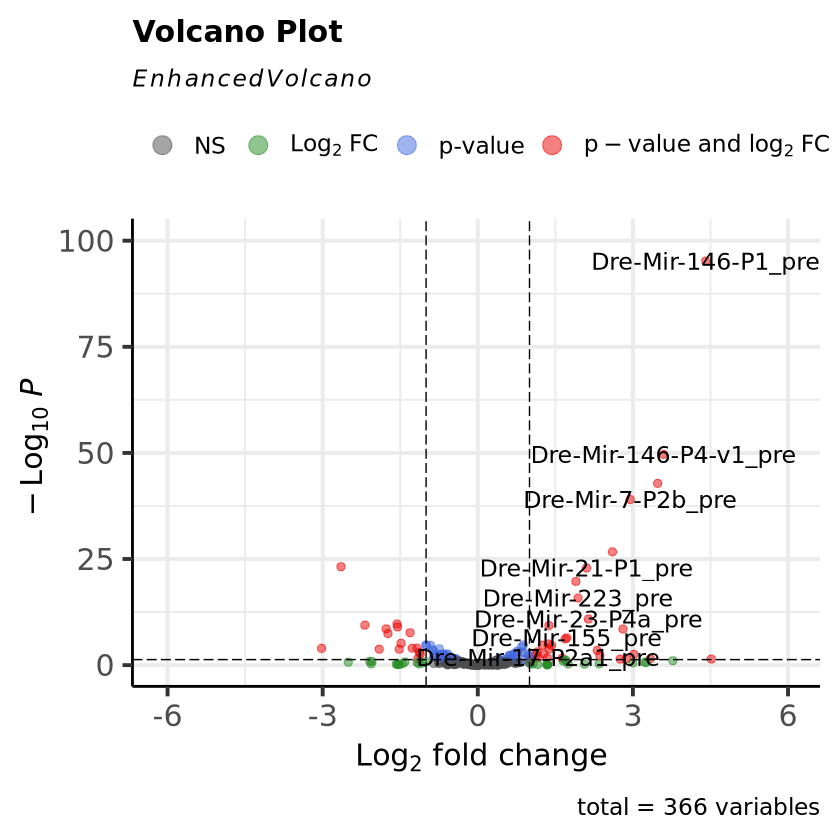

In [21]:
#Volcano Plot
EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'pvalue',
    pCutoff = 0.05,
    FCcutoff = 1.0,
    title = 'Volcano Plot')


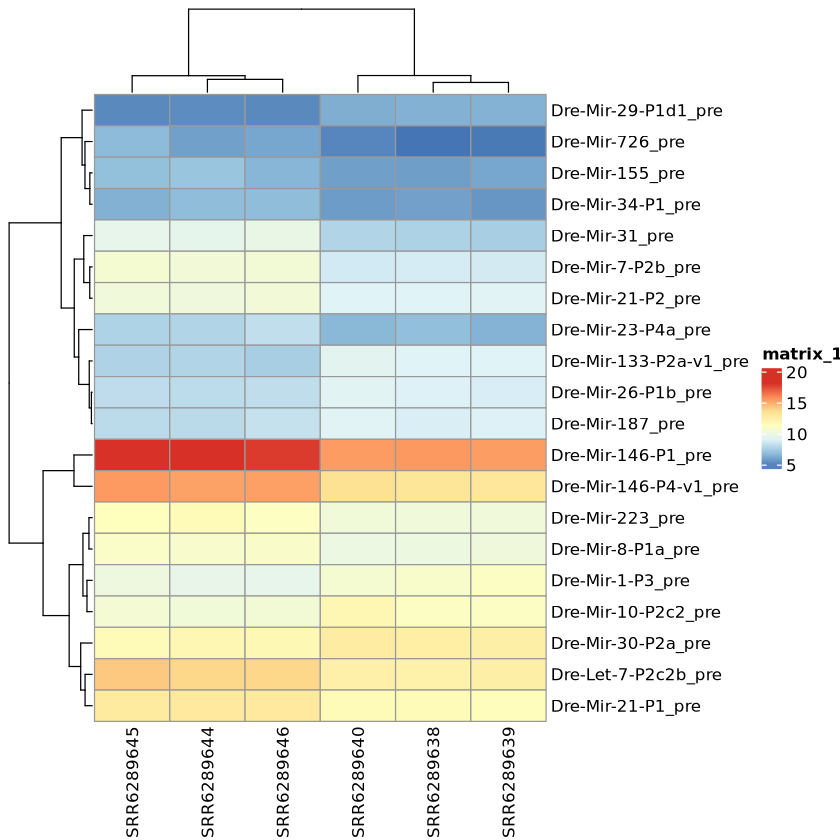

In [26]:
rld <- rlog(dds)
# Select top 20 genes by adjusted p-value
top_genes <- head(order(res$padj), 20)
mat <- assay(rld)[top_genes, ]

# Plot the heatmap
pheatmap(mat, cluster_rows = TRUE, cluster_cols = TRUE)


using ntop=500 top features by variance



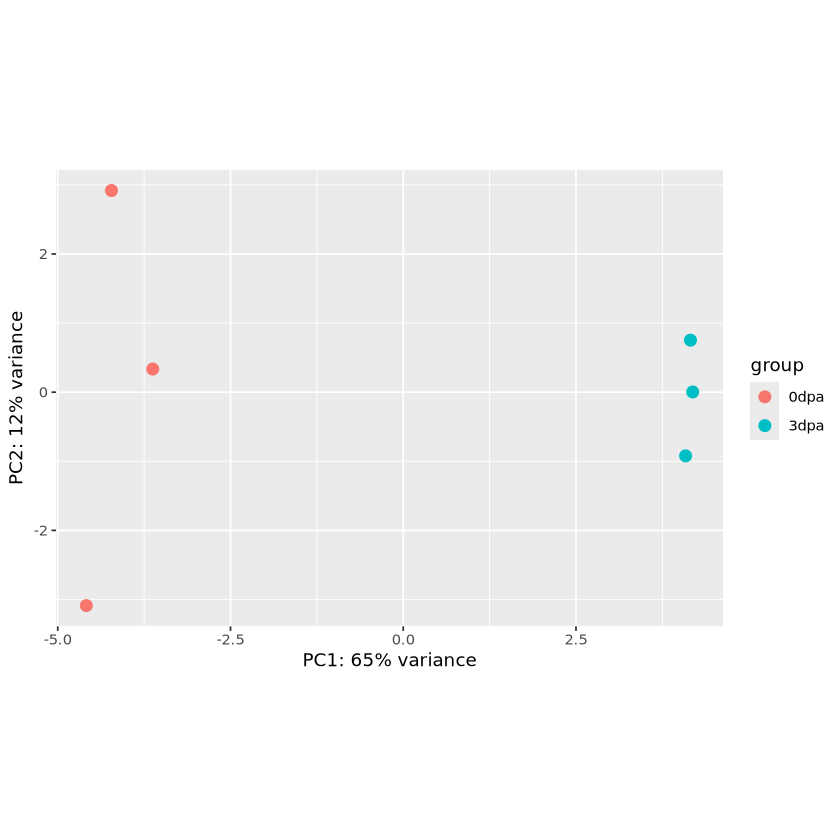

In [23]:
#PCA plot
rld <- rlog(dds) 
plotPCA(rld, intgroup = "condition")


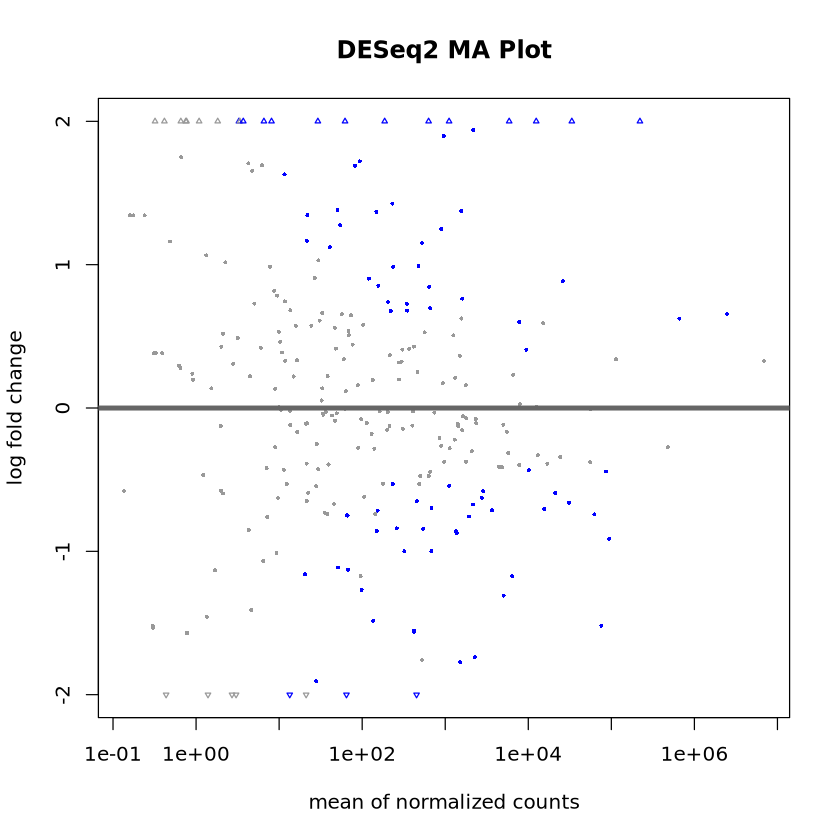

In [24]:
#MA plot
plotMA(res, main="DESeq2 MA Plot", ylim=c(-2, 2))


Warning message in FUN(X[[i]], ...):
“internal error 1 in R_decompress1 with libdeflate”
ERROR while rich displaying an object: Error in FUN(X[[i]], ...): lazy-load database '/home/ec2-user/anaconda3/envs/R/lib/R/library/base64enc/R/base64enc.rdb' is corrupt

Traceback:
1. sapply(x, f, simplify = simplify)
2. lapply(X = X, FUN = FUN, ...)
3. FUN(X[[i]], ...)
4. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
5. tryCatchList(expr, classes, parentenv, handlers)
6. tryCatchOne(expr, names, parentenv, handlers[[1L]])
7. doTryCatch(return(expr), name, parentenv, handler)
8. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2r

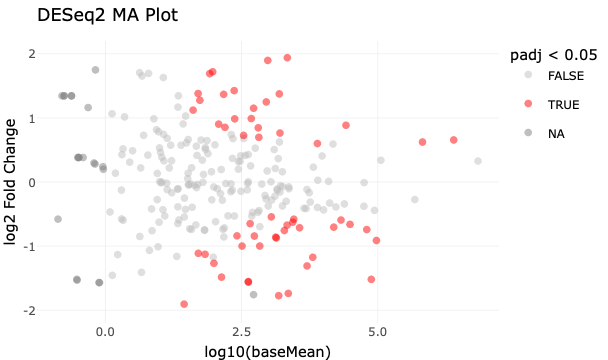

In [25]:
# Interactive MA Plot
res_df <- as.data.frame(res)

p <- ggplot(res_df, aes(x=log10(baseMean), y=log2FoldChange, 
                        text=paste("Gene: ", rownames(res_df)), 
                        color=padj < 0.05)) +
  geom_point(alpha=0.5) +
  scale_color_manual(values=c("grey", "red")) + # Highlight significant genes
  labs(title="DESeq2 MA Plot", x="log10(baseMean)", y="log2 Fold Change") +
  theme_minimal() +
  ylim(-2, 2)

interactive_plot <- ggplotly(p, tooltip="text")
interactive_plot
